In [11]:
# !pip install mtcnn opencv-contrib-python scikit-image

In [12]:
# ===================================================================
# COMPLETE WORKFLOW: TRAIN MODEL + PROCESS VIDEO
# ===================================================================

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow logs
import warnings
warnings.filterwarnings('ignore')

import cv2
import numpy as np
from mtcnn import MTCNN
from skimage import feature
from sklearn import svm
import joblib
import matplotlib.pyplot as plt
from IPython.display import Video, display

# Configuration
DATASET_PATH = "/kaggle/input/pins-face-recognition/105_classes_pins_dataset"
INPUT_VIDEO = "/kaggle/input/implementation-v2-input-video/implementation_v2-input_video.mp4"
OUTPUT_VIDEO = "/kaggle/working/output_video.mp4"
MODEL_PATH = "/kaggle/working/face_recognition_model.pkl"

NUM_PEOPLE = 15
NUM_IMAGES_PER_PERSON = 10

print("=" * 70)
print("COMPLETE FACE RECOGNITION PIPELINE: TRAINING + VIDEO PROCESSING")
print("=" * 70)

COMPLETE FACE RECOGNITION PIPELINE: TRAINING + VIDEO PROCESSING


In [13]:
# ===================================================================
# STEP 1: DEFINE FUNCTIONS (from TP)
# ===================================================================

def detect_faces(image):
    """Detect faces using MTCNN"""
    detector = MTCNN()
    faces = detector.detect_faces(image)
    return faces

def extract_lbp(image):
    """Extract LBP features from face image"""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = feature.local_binary_pattern(gray, P=8, R=1, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    return hist

def train_svm(features, labels):
    """Train SVM model with linear kernel"""
    model = svm.SVC(kernel='linear', probability=True)
    model.fit(features, labels)
    return model

def load_or_train_svm(training_data, training_labels, model_path):
    """Load existing model or train new one"""
    if os.path.exists(model_path):
        try:
            model = joblib.load(model_path)
            print("✓ Existing SVM model loaded from file")
            return model
        except:
            print("⚠ Could not load model, will train new one")
    
    print("✗ Model not found. Training new SVM model...")
    model = train_svm(training_data, training_labels)
    joblib.dump(model, model_path)
    print(f"✓ New SVM model trained and saved to {model_path}")
    return model

print('DONE!')

DONE!


In [14]:
# ===================================================================
# STEP 2: PREPARE TRAINING DATA
# ===================================================================

print("\n" + "=" * 70)
print("STEP 1/3: EXTRACTING TRAINING DATA")
print("=" * 70)

features = []
labels = []
label_map = {}
current_label = 0

detector = MTCNN()

if not os.path.exists(DATASET_PATH):
    print(f"✗ Dataset not found at: {DATASET_PATH}")
    print("Please check the dataset path!")
    exit()

people_list = sorted(os.listdir(DATASET_PATH))[:NUM_PEOPLE]

for person_name in people_list:
    person_dir = os.path.join(DATASET_PATH, person_name)
    
    if not os.path.isdir(person_dir):
        continue
    
    label_map[current_label] = person_name
    person_faces = 0
    
    for img_name in os.listdir(person_dir)[:NUM_IMAGES_PER_PERSON]:
        img_path = os.path.join(person_dir, img_name)
        
        try:
            image = cv2.imread(img_path)
            if image is None:
                continue
            
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            faces_detected = detect_faces(image_rgb)
            
            if faces_detected and len(faces_detected) > 0:
                face_data = faces_detected[0]
                x, y, width, height = face_data['box']
                
                x, y = max(0, x), max(0, y)
                detected_face = image[y:y+height, x:x+width]
                
                if detected_face.size == 0:
                    continue
                
                detected_face = cv2.resize(detected_face, (100, 100))
                lbp_features = extract_lbp(detected_face)
                
                features.append(lbp_features)
                labels.append(current_label)
                person_faces += 1
        
        except Exception as e:
            continue
    
    if person_faces > 0:
        print(f"Label {current_label}: {person_name:30s} → {person_faces} faces")
        current_label += 1

print(f"\n{'=' * 70}")
print(f"TOTAL TRAINING SAMPLES: {len(features)}")
print(f"TOTAL CLASSES: {len(set(labels))}")
print(f"{'=' * 70}")


STEP 1/3: EXTRACTING TRAINING DATA
Label 0: pins_Adriana Lima              → 10 faces
Label 1: pins_Alex Lawther              → 10 faces
Label 2: pins_Alexandra Daddario        → 10 faces
Label 3: pins_Alvaro Morte              → 10 faces
Label 4: pins_Amanda Crew               → 10 faces
Label 5: pins_Andy Samberg              → 10 faces
Label 6: pins_Anne Hathaway             → 10 faces
Label 7: pins_Anthony Mackie            → 10 faces
Label 8: pins_Avril Lavigne             → 10 faces
Label 9: pins_Ben Affleck               → 10 faces
Label 10: pins_Bill Gates                → 10 faces
Label 11: pins_Bobby Morley              → 10 faces
Label 12: pins_Brenton Thwaites          → 10 faces
Label 13: pins_Brian J. Smith            → 10 faces
Label 14: pins_Brie Larson               → 10 faces

TOTAL TRAINING SAMPLES: 150
TOTAL CLASSES: 15


In [15]:
# ===================================================================
# STEP 3: TRAIN MODEL
# ===================================================================

print("\n" + "=" * 70)
print("STEP 2/3: TRAINING SVM MODEL")
print("=" * 70)

if len(features) < 2:
    print("✗ Not enough training data! Need at least 2 samples.")
    exit()

features = np.array(features)
labels = np.array(labels)

# Train or load model
model = load_or_train_svm(features, labels, MODEL_PATH)

# Test model accuracy
all_predictions = model.predict(features)
accuracy = (all_predictions == labels).sum() / len(labels) * 100
print(f"\n✓ Model training accuracy: {accuracy:.2f}%")
print(f"✓ Model ready for video processing!")


STEP 2/3: TRAINING SVM MODEL
✓ Existing SVM model loaded from file

✓ Model training accuracy: 18.00%
✓ Model ready for video processing!


In [16]:
# ===================================================================
# STEP 4: PROCESS VIDEO
# ===================================================================

print("\n" + "=" * 70)
print("STEP 3/3: PROCESSING VIDEO")
print("=" * 70)

if not os.path.exists(INPUT_VIDEO):
    print(f"✗ Video not found at: {INPUT_VIDEO}")
    print("Please verify the video path!")
    exit()

print(f"✓ Input video found: {INPUT_VIDEO}")

# Open video
cap = cv2.VideoCapture(INPUT_VIDEO)

# Get video properties
fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

print(f"\nVideo Properties:")
print(f"  - Resolution: {width}x{height}")
print(f"  - FPS: {fps}")
print(f"  - Total Frames: {total_frames}")
print(f"  - Duration: {total_frames/fps:.2f} seconds")

# Create video writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(OUTPUT_VIDEO, fourcc, fps, (width, height))

print(f"\n✓ Processing video...")
print("=" * 70)

frame_count = 0
faces_detected_total = 0

# Process every frame
while True:
    ret, frame = cap.read()
    
    if not ret:
        break
    
    frame_count += 1
    
    # Show progress
    if frame_count % 30 == 0:
        progress = (frame_count / total_frames) * 100
        print(f"Processing frame {frame_count}/{total_frames} ({progress:.1f}%)")
    
    try:
        # Detect faces
        faces = detect_faces(frame)
        
        if faces:
            faces_detected_total += len(faces)
        
        for face in faces:
            x, y, width, height = face['box']
            
            # Validate coordinates
            x = max(0, x)
            y = max(0, y)
            width = min(width, frame.shape[1] - x)
            height = min(height, frame.shape[0] - y)
            
            if width <= 0 or height <= 0:
                continue
            
            detected_face = frame[y:y+height, x:x+width]
            
            if detected_face.size == 0:
                continue
            
            detected_face_resized = cv2.resize(detected_face, (100, 100))
            lbp_features = extract_lbp(detected_face_resized)
            
            # Predict using trained model
            prediction = model.predict([lbp_features])[0]
            probabilities = model.predict_proba([lbp_features])[0]
            confidence = max(probabilities) * 100
            
            person_name = label_map.get(prediction, "Unknown")
            
            # Draw rectangle
            cv2.rectangle(frame, (x, y), (x + width, y + height), (0, 255, 0), 2)
            
            # Draw text with background
            text = f"{person_name[:20]}"
            conf_text = f"{confidence:.1f}%"
            
            cv2.rectangle(frame, (x, y - 35), (x + 200, y), (0, 255, 0), -1)
            cv2.putText(frame, text, (x + 5, y - 20), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
            cv2.putText(frame, conf_text, (x + 5, y - 5), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 0), 1)
    
    except Exception as e:
        # Continue processing even if one frame fails
        pass
    
    # Write frame
    out.write(frame)

# Release resources
cap.release()
out.release()

print("=" * 70)
print(f"✓ VIDEO PROCESSING COMPLETE!")
print(f"  - Frames processed: {frame_count}")
print(f"  - Total faces detected: {faces_detected_total}")
if frame_count > 0:
    print(f"  - Average faces per frame: {faces_detected_total/frame_count:.2f}")
print(f"\n✓ Output saved to: {OUTPUT_VIDEO}")
print("=" * 70)


STEP 3/3: PROCESSING VIDEO
✓ Input video found: /kaggle/input/implementation-v2-input-video/implementation_v2-input_video.mp4

Video Properties:
  - Resolution: 1080x1920
  - FPS: 30
  - Total Frames: 153
  - Duration: 5.10 seconds

✓ Processing video...
Processing frame 30/153 (19.6%)
Processing frame 60/153 (39.2%)
Processing frame 90/153 (58.8%)
Processing frame 120/153 (78.4%)
Processing frame 150/153 (98.0%)
✓ VIDEO PROCESSING COMPLETE!
  - Frames processed: 153
  - Total faces detected: 144
  - Average faces per frame: 0.94

✓ Output saved to: /kaggle/working/output_video.mp4



DISPLAYING SAMPLE FRAMES


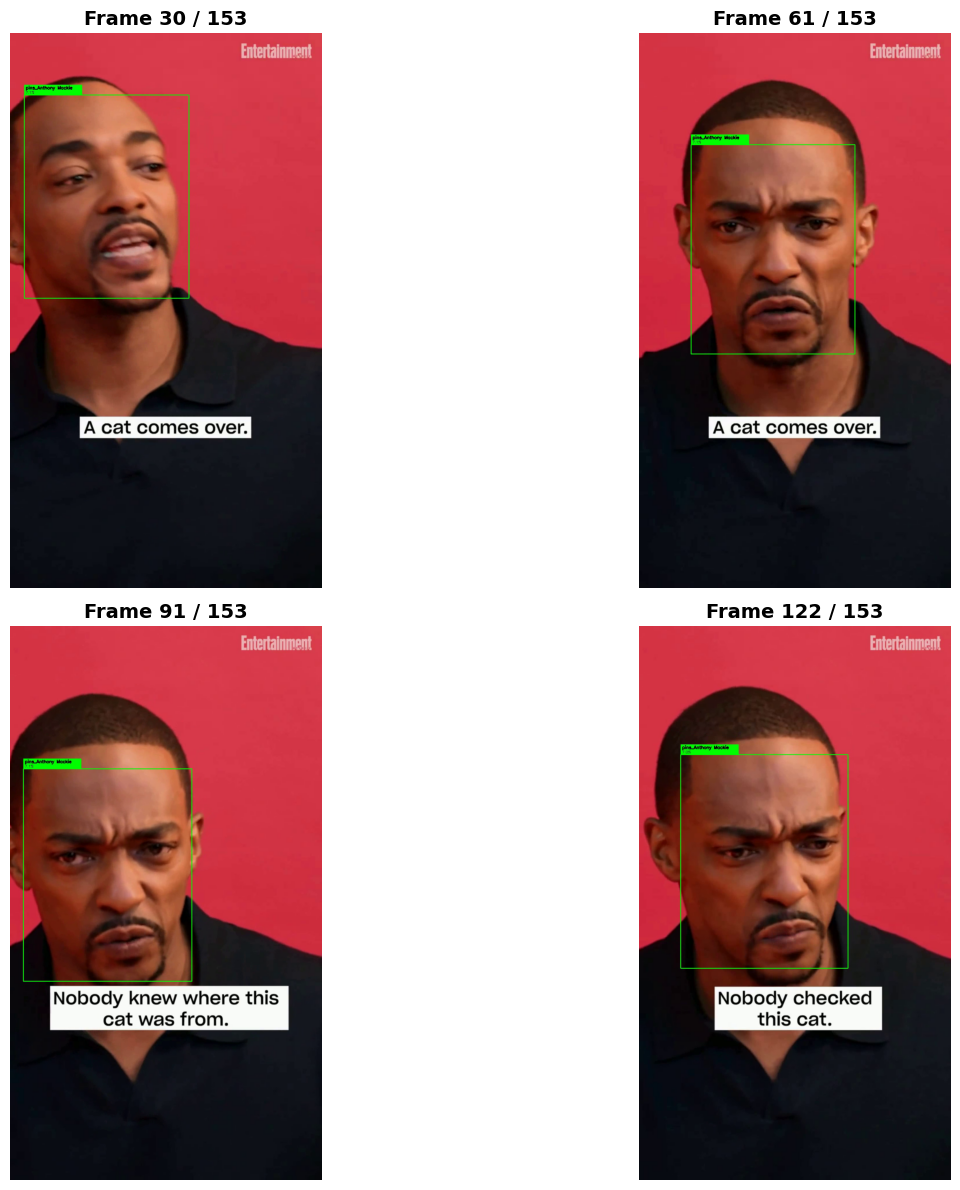

✓ Sample frames displayed above

VIDEO PLAYBACK



✓ Video displayed above!

ALL DONE! ✓

Output files in /kaggle/working/:
  1. /kaggle/working/output_video.mp4
  2. /kaggle/working/face_recognition_model.pkl
  3. sample_frames.png


In [17]:
# ===================================================================
# STEP 5: DISPLAY RESULTS
# ===================================================================

print("\n" + "=" * 70)
print("DISPLAYING SAMPLE FRAMES")
print("=" * 70)

# Extract sample frames
cap = cv2.VideoCapture(OUTPUT_VIDEO)
total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

sample_frames = []
frame_indices = [total//5, 2*total//5, 3*total//5, 4*total//5]

for idx in frame_indices:
    cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
    ret, frame = cap.read()
    if ret:
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        sample_frames.append(frame_rgb)

cap.release()

# Display frames
if sample_frames:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for idx, frame in enumerate(sample_frames):
        axes[idx].imshow(frame)
        axes[idx].set_title(f"Frame {frame_indices[idx]} / {total}", fontsize=14, weight='bold')
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig('/kaggle/working/sample_frames.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("✓ Sample frames displayed above")

# Display video
print("\n" + "=" * 70)
print("VIDEO PLAYBACK")
print("=" * 70)

try:
    display(Video(OUTPUT_VIDEO, width=800, embed=True))
    print("\n✓ Video displayed above!")
except Exception as e:
    print(f"⚠ Could not display video inline")
    print(f"Download it from: {OUTPUT_VIDEO}")

print("\n" + "=" * 70)
print("ALL DONE! ✓")
print("=" * 70)
print(f"\nOutput files in /kaggle/working/:")
print(f"  1. {OUTPUT_VIDEO}")
print(f"  2. {MODEL_PATH}")
print(f"  3. sample_frames.png")
print("=" * 70)